This notebook contains all of the initial setup of `optimization_notebook.ipynb` to establish model/parameterization, but then computes the SVD calibration directions used to calibrate the particular pulse we used.

In [1]:
import sys
sys.path.insert(1, 'src/')

## 1. Defining operators and constants

First, we'll define operators and constants.

In [2]:
import jax
jax.config.update("jax_enable_x64", True)

# tell JAX we are using CPU
jax.config.update('jax_platform_name', 'cpu')

import numpy as np

# dimension
dim = 4

# some fixed model parameters
freq = 4.725
anharm = -0.35
r = 0.08

# operators
a = np.diag(np.sqrt(np.arange(1, dim)), 1) + 0j
adag = np.diag(np.sqrt(np.arange(1, dim)), -1) + 0j
N = np.diag(np.arange(dim)) + 0j

static_hamiltonian = 2 * np.pi * freq * N + np.pi * anharm * N * (N - np.eye(dim)) + 0j
drive_hamiltonian_X = 2 * np.pi * r * (a + adag) + 0j

freq_operator = N + 0j

Question: Is the drive Hamiltonian in the RWA divided by 2? I always forget.

## 2. Define the signal parameterization

A way of parameterizing an envelope we currently use regularly is encoded in the function `chebyshev_parameterization`.

The doc string for the function goes into the details of how it constructs a signal. Note that the number of chebyshev polynomials used in the parameterization is determined by the length of the parameter vector.

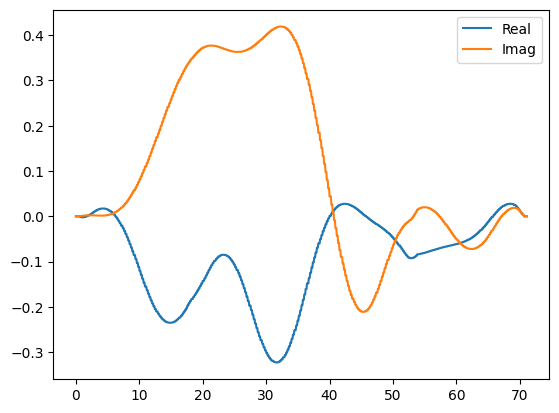

In [3]:
from parameterization import chebyshev_parameterization

dt = 1 / 4.5 # sample width
n_steps = 240 # base number of time steps
n_zeros = 40 # amount of padding used in convolution for smoothing
cutoff_freq = 0.3
num_params = 10

T = (n_steps + 2 * n_zeros) * dt

example_sig = chebyshev_parameterization(
    I_params=np.random.rand(10),
    Q_params=np.random.rand(10),
    dt=dt,
    cutoff_freq=cutoff_freq,
    n_steps=n_steps,
    n_zeros=n_zeros
)
example_sig.draw(0, dt * len(example_sig.samples), 1000, function="envelope")

For the parameterization to be consumable by the helper functions, we need to define a dictionary of the form: `{signal_name: parameterization}`, where `parameterization` is a function on the input dictionary of parameters, and returns a Qiskit Dynamics signal.

In this case, since we did the RWA by hand, we need to parameterize two separate signals for the I and Q components.

In [4]:
# use the same function for I and Q components
signal_func = lambda x, y, phase: chebyshev_parameterization(
    I_params=x,
    Q_params=y,
    dt=dt,
    n_steps=n_steps,
    n_zeros=n_zeros,
    phase=phase,
    cutoff_freq=cutoff_freq,
    carrier_freq=freq
)

pi2 = np.pi/2

signal_parameterizations = {
    "sigX": lambda opt_parameters: signal_func(
        x=opt_parameters["I_params"],
        y=opt_parameters["Q_params"],
        phase=opt_parameters["phase"]
    )
}

## 3. Define the model and perturbations

Here we define the model as a Hamiltonian in a dictionary format. The format is: `{signal_name: operator}`, with the signal name `drift` reserved for the constant part of the Hamiltonian.

In [5]:
model = {
    "drift": static_hamiltonian,
    "sigX": drive_hamiltonian_X
}

The perturbations are defined similarly in a dictionary format. 

Aside: This is kind of annoying, but the keys for the perturbations need to be collections of labels (more generally to allow for higher level perturbations), so here we use `frozenset`.

In [6]:
perturbations = {
    frozenset(["freq"]): {"drift": freq_operator},
    frozenset(["amp"]): {
        "sigX": drive_hamiltonian_X / (2 * np.pi * r)
    },
    frozenset(["energy"]): {"drift": N} # setting energy penalty to higher levels
}

Finally, we can set a rotating frame to perform the computation in.

In [7]:
# remove the diag if model is not diagonal!
rotating_frame = np.diag(model["drift"])

## 4. Define objective functions and weights

Lastly, we define the objective functions we want to compute. This will be a minimization problem.

In [8]:
from objectives import fidelity, traceless_hs_norm
import jax.numpy as jnp
from scipy.linalg import expm

X = np.array([[0., 1.], [1., 0.]])

#U_target = X
U_target = expm(-1j * (np.pi/4) * X)

def robustness(results, name):
    mat = results.perturbation_data.get_item([name])[-1]
    return traceless_hs_norm(mat[:, 0:2])

P = jnp.diag(np.append(np.ones(2), np.zeros(dim-2)))
ave_energy_normalization = jnp.real(jnp.trace(N)) * T

def ave_energy(results):
    mat = 1j * results.perturbation_data.get_item(["energy"])[-1]
    return jnp.real(jnp.trace(P @ mat @ P)) / ave_energy_normalization
                    
def final_leakage(results):
    # mapping of input computational subspace to output leakage
    U = results.y[-1][2:, 0:2]
    return jnp.linalg.norm(U)

objective_functions = {
    "infidelity": lambda results: 1 - fidelity(results.y[-1], U_target),
    "freq_robustness": lambda results: robustness(results, "freq") / T,
    "amp_robustness": lambda results: robustness(results, "amp") / T,
    "ave_energy": ave_energy,
    "final_leakage": final_leakage
}
                    
objective_weights = {
    "infidelity": 1.,
    "freq_robustness": 5.,
    "amp_robustness": 5.,
    "ave_energy": 0.1,
    "final_leakage": 1.
}

In [9]:
U_target

array([[0.70710678+0.j        , 0.        -0.70710678j],
       [0.        -0.70710678j, 0.70710678+0.j        ]])

## 5. Compute objective function

In [10]:
from optimization_workflow_helpers import perturbative_objective_function

objective = lambda params: perturbative_objective_function(
    opt_parameters=params,
    signal_parameterizations=signal_parameterizations,
    model=model,
    rotating_frame=rotating_frame,
    perturbations=perturbations,
    t_span=[0, T],
    objective_functions=objective_functions,
    objective_weights=objective_weights,
    expansion_method="dyson",
    expansion_order=1,
    integration_method="jax_odeint",
    atol=1e-12,
    rtol=1e-12
)

## 8. Validate performance

In [11]:
# best performing parameters
opt_params ={
    'I_params': jnp.array([ 0.08432198, -4.0976586 , -5.781624  , -8.55092   , -5.458835  ,
         0.18667547,  6.4387    ,  7.008362  ,  4.511104  ,  1.9051901 ,
        -3.574085  , -0.0216548 ,  1.9599719 ,  1.7783914 , -1.989886  ,
        -0.8524528 , -0.24872959,  1.416902  ,  0.673748  ,  0.47093   ]), 
    'Q_params': jnp.array([ 4.198883  , -1.4582886 ,  1.8140087 , -1.2474163 ,  1.5403961 ,
        -2.8162842 , -3.8921468 ,  1.7678754 , -3.2438188 ,  2.8344529 ,
         3.2317514 , -0.57384133,  0.03444064,  1.1026036 ,  2.0887687 ,
        -0.35428742, -3.036116  ,  2.3634195 , -1.1164097 ,  0.7448784 ]), 
    'phase': jnp.array(2.5150995)
}

In [12]:
from numpy.fft import fft, fftfreq

sig = signal_parameterizations['sigX'](opt_params)
ft = fft(sig.samples)
ft_freq = fftfreq(len(sig.samples), d=dt)
idx = np.argmin(ft_freq)
ft_freq = np.append(ft_freq[idx:], ft_freq[:idx])
ft = np.append(ft[idx:], ft[:idx])

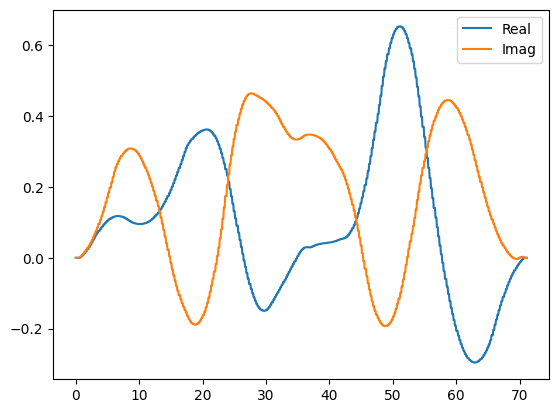

In [13]:
sig.draw(0, T, 1000, function="envelope")

In [14]:
np.max(np.abs(sig.samples))

0.6633918670980383

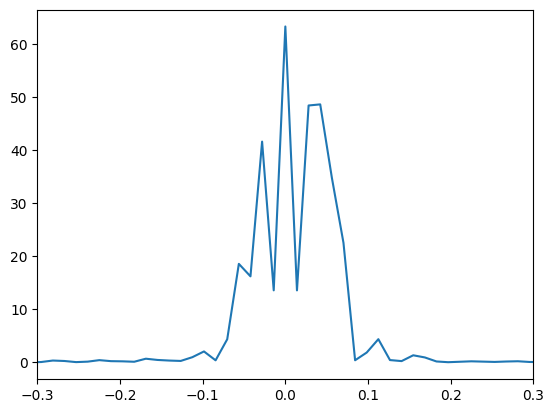

In [15]:
import matplotlib.pyplot as plt
plt.xlim([-0.3, 0.3])
plt.plot(ft_freq, np.abs(ft))

In [16]:
from optimization_workflow_helpers import optimization_perturbation_sim

ode_result = optimization_perturbation_sim(
    opt_parameters=opt_params,
    signal_parameterizations=signal_parameterizations,
    model=model,
    rotating_frame=rotating_frame,
    perturbations=perturbations,
    t_span=[0, T],
    expansion_method="dyson",
    expansion_order=1,
    integration_method="jax_odeint",
    atol=1e-12,
    rtol=1e-12
)

In [17]:
opt_objectives = {k: func(ode_result) for k, func in objective_functions.items()}

In [18]:
opt_objectives

{'infidelity': Array(6.92706179e-07, dtype=float64),
 'freq_robustness': Array(1.09142136e-05, dtype=float64),
 'amp_robustness': Array(6.72505966e-05, dtype=float64),
 'ave_energy': Array(0.16719912, dtype=float64),
 'final_leakage': Array(1.40372478e-05, dtype=float64)}

Sim unitary

In [19]:
from qiskit_dynamics import solve_lmde, RotatingFrame


rotating_frame = RotatingFrame(model["drift"])

freq_op = 2 * np.pi * N
y0 = np.eye(dim, dtype=complex)

def sim_func(sig_params, v_dev, r_dev, amp):
    
    sig_params = sig_params.copy()
    sig_params["phase"] = 0.

    sigX = signal_parameterizations["sigX"](sig_params)
    
    
    def model_func(t):
        generator = -1j * (
            model["drift"] + amp * sigX(t) * (1 + r_dev) * model["sigX"] +
            v_dev * freq_op
        )
        return rotating_frame.generator_into_frame(t, generator)

    result = solve_lmde(
        generator=model_func,
        t_span=[0, T],
        y0=y0,
        method="jax_odeint",
        atol=1e-12,
        rtol=1e-12
    )
    # return only the portion for the computational subspace
    return result.y[-1][:2, :2]



Plot excitation from the ground state v.s. overall pulse amplitude.

In [20]:
amp_list = jnp.linspace(0.0, 1.7, 151) # what Emma used in her notebook

In [21]:
from jax import jit
fast_sim = jit(lambda amp: sim_func(opt_params, 0., 0., amp))

populations = []
for amp in amp_list:
    U = fast_sim(amp)
    populations.append(jnp.abs(U[1, 0])**2)

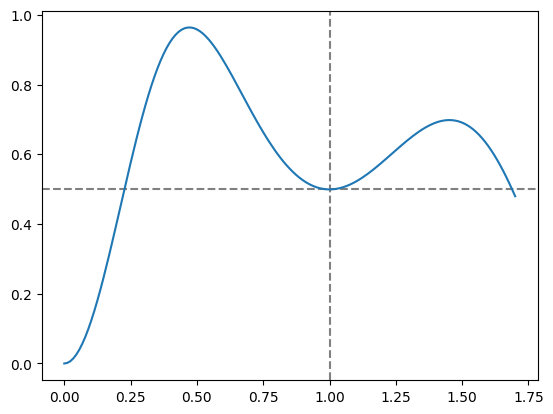

In [22]:
import matplotlib.pyplot as plt
plt.axvline(1.,color='gray',linestyle='dashed')
plt.axhline(0.5,color='gray',linestyle='dashed')
plt.plot(amp_list, populations)

Plot excitation from the ground state as a function of drive frequency offset.

In [23]:
from jax import jit
fast_sim = jit(lambda vdev: sim_func(opt_params, vdev, 0., 1.))

vdev_list = jnp.linspace(-0.1, 0.1, 101)
vdev_populations = []
for vdev in vdev_list:
    U = fast_sim(vdev)
    vdev_populations.append(jnp.abs(U[1, 0])**2)

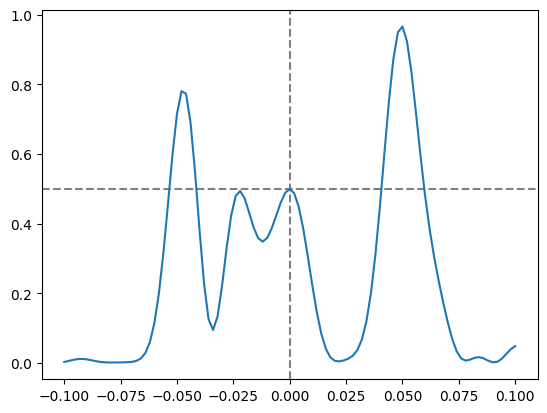

In [24]:
import matplotlib.pyplot as plt
plt.axvline(0.,color='gray',linestyle='dashed')
plt.axhline(0.5,color='gray',linestyle='dashed')
plt.plot(vdev_list, vdev_populations)

## 9. Compute SVD directions for calibration

Next, compute the SVD directions for the pulse to be used in calibration.

In [25]:
# in computing the directions I don't want to include phase, as it will be tuned independently
params = opt_params.copy()
del params["phase"]

First, define the function for the unitary simulation for a specific value of frequency/drive deviation.

In [26]:
from qiskit_dynamics import solve_lmde, RotatingFrame


rotating_frame = RotatingFrame(model["drift"])

freq_op = 2 * np.pi * 5. * N
y0 = np.eye(dim, dtype=complex)

def sim_func(sig_params, v_dev, r_dev, amp):
    
    sig_params = sig_params.copy()
    sig_params["phase"] = 0.

    sigX = signal_parameterizations["sigX"](sig_params)
    
    
    def model_func(t):
        generator = -1j * (
            model["drift"] + amp * sigX(t) * (1 + r_dev) * model["sigX"] +
            v_dev * freq_op
        )
        return rotating_frame.generator_into_frame(t, generator)

    result = solve_lmde(
        generator=model_func,
        t_span=[0, T],
        y0=y0,
        method="jax_odeint",
        atol=1e-12,
        rtol=1e-12
    )
    # return only the portion for the computational subspace
    return result.y[-1][:2, :2]



Define the function that will run the above over a loop of freq/amp variations.

In [27]:
from jax import vmap

# deviations are a percentage
# we should revisit the required width of these
v_deviations = jnp.linspace(-1e-4, 1e-4, 3)
r_deviations = jnp.linspace(-5e-2, 5e-2, 3)

def collective_sim_func(sig_params):
    f = lambda x, y: sim_func(sig_params, x, y, 1.)
    
    # attempts to vectorize this were not working, need to investigate or maybe use
    # a different JAX loop construct
    outcomes = dict()
    for v_idx, v_dev in enumerate(v_deviations):
        for r_idx, r_dev in enumerate(r_deviations):
            outcomes[(v_idx, r_idx)] = f(v_dev, r_dev)
    
    return outcomes

Construct the calibration directions.

In [28]:
from directions_analysis import SVDCalibrationDirections

svd_directions = SVDCalibrationDirections(params, f=collective_sim_func)

This is quite slow - I suspect that proper usage of JAX transformations could help with this, though not sure to what extent.

This object contains generalized SVD decomposition (generalized to arbitrary PyTrees).

In [29]:
svd_directions.S

Array([7.61484318e+00, 6.34206162e+00, 4.41117349e+00, 3.52934828e-01,
       1.67516604e-01, 1.07556328e-01, 6.77623448e-02, 5.85922422e-02,
       2.67613269e-02, 6.32814688e-03, 5.62315917e-03, 1.95039192e-03,
       5.73373355e-04, 2.59764318e-04, 2.03212435e-04, 5.38436022e-05,
       2.22168050e-05, 1.59267371e-05, 7.88914856e-06, 5.28673215e-06,
       3.23468746e-06, 1.65027606e-06, 1.22669173e-06, 6.47623763e-07,
       6.03555924e-07, 3.65503289e-07, 2.34376500e-07, 2.17297983e-07,
       9.07027870e-08, 7.14657361e-08, 5.37703082e-08, 3.73468787e-08,
       2.54572069e-08, 1.54134194e-08, 9.23228918e-09, 4.88440738e-09,
       1.24199179e-09, 3.86157401e-10, 1.62376245e-10, 3.17409736e-11],      dtype=float64)

In [30]:
svd_directions.Vh

{'I_params': Array([[ 4.96774433e-01, -4.39219575e-01,  7.68795650e-02,
          3.29039617e-01, -3.37245318e-01,  1.67246344e-01,
         -1.09646321e-01,  1.24800311e-01,  3.84704564e-02,
         -1.97034240e-01,  1.48230892e-01, -9.72538728e-02,
         -1.42250977e-02,  8.84844155e-02,  1.28307394e-03,
         -8.84181948e-02,  1.35745133e-01, -2.38635216e-02,
         -1.65360934e-01,  1.98194864e-01],
        [ 7.06769381e-02, -2.33713257e-02, -4.99289576e-02,
          3.56545289e-02,  6.67264354e-02, -7.63162477e-02,
         -4.29856302e-02,  8.14803369e-02, -1.27357711e-02,
         -1.08189559e-02, -3.50752609e-03, -1.71965347e-02,
          4.08443001e-02, -1.87886755e-02, -8.72290045e-03,
          8.81462954e-03,  7.56816895e-03, -2.18251951e-02,
         -2.10586001e-02,  6.02392350e-02],
        [-7.26931121e-02, -1.75108002e-01,  2.45162147e-01,
          9.45131093e-02, -2.73721190e-01,  1.23971326e-01,
          8.99533899e-02,  1.38630852e-02, -6.52482608e-02,


We can look at the shape of the perturbations. The method `SVDCalibrationDirections.right_SV_linear_combo` computes linear combinations of the perturbations with a given coefficient. Note that coefficients of length less than the actual dimension of `Vh` can be supplied, and additional dimensions implicitly have a coefficient of `0.`.

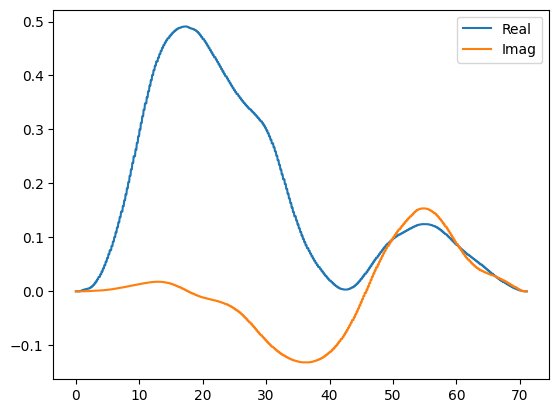

In [31]:
coeffs = jnp.array([1., 0., 0., 0., 0.])

perturb_params = svd_directions.right_SV_linear_combo(coeffs)
perturb_params["phase"] = 0.
perturb_sig = signal_parameterizations["sigX"](perturb_params)

perturb_sig.draw(0, T, 1000, function="envelope")

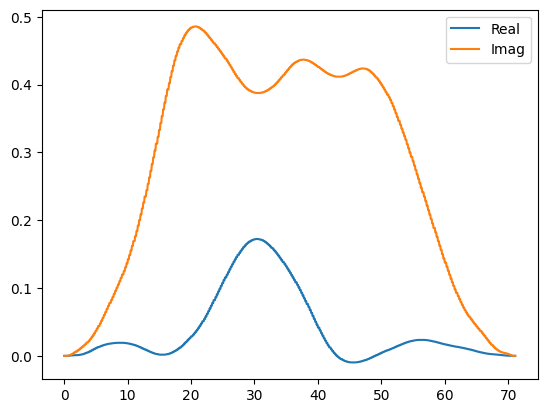

In [32]:
coeffs = jnp.array([0., 1., 0., 0., 0.])

perturb_params = svd_directions.right_SV_linear_combo(coeffs)
perturb_params["phase"] = 0.
perturb_sig = signal_parameterizations["sigX"](perturb_params)

perturb_sig.draw(0, T, 1000, function="envelope")

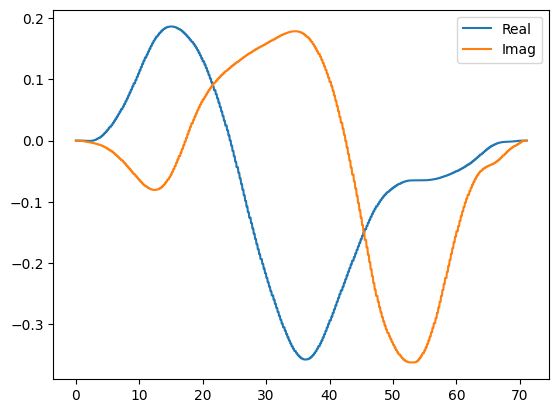

In [33]:
coeffs = jnp.array([0., 0., 1., 0., 0.])

perturb_params = svd_directions.right_SV_linear_combo(coeffs)
perturb_params["phase"] = 0.
perturb_sig = signal_parameterizations["sigX"](perturb_params)

perturb_sig.draw(0, T, 1000, function="envelope")

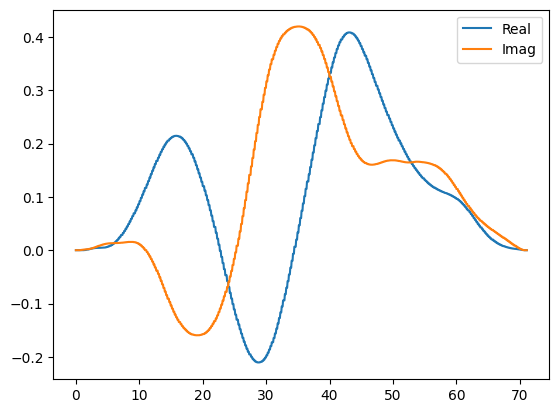

In [34]:
coeffs = jnp.array([0., 0., 0., 1., 0.])

perturb_params = svd_directions.right_SV_linear_combo(coeffs)
perturb_params["phase"] = 0.
perturb_sig = signal_parameterizations["sigX"](perturb_params)

perturb_sig.draw(0, T, 1000, function="envelope")

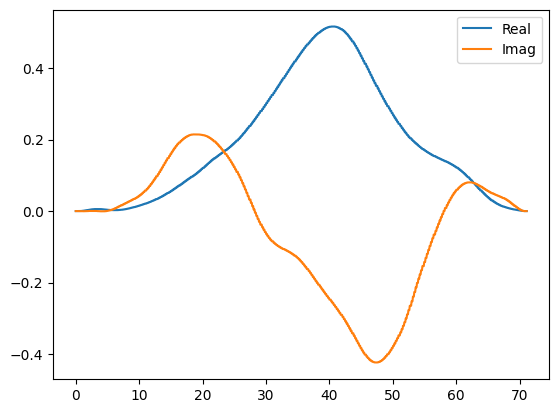

In [35]:
coeffs = jnp.array([0., 0., 0., 0., 1.])

perturb_params = svd_directions.right_SV_linear_combo(coeffs)
perturb_params["phase"] = 0.
perturb_sig = signal_parameterizations["sigX"](perturb_params)

perturb_sig.draw(0, T, 1000, function="envelope")

`SVDCalibrationDirections.right_SV_linear_combo` can also add the perturbation to the original parameter arguments at which the Jacobian/SVD were computed by setting `translate_args=True`.

In [36]:
svd_directions.right_SV_linear_combo(jnp.array([0.]), translate_args=True)

{'I_params': Array([ 0.08432198, -4.0976586 , -5.781624  , -8.55092   , -5.458835  ,
         0.18667547,  6.4387    ,  7.008362  ,  4.511104  ,  1.9051901 ,
        -3.574085  , -0.0216548 ,  1.9599719 ,  1.7783914 , -1.989886  ,
        -0.8524528 , -0.24872959,  1.416902  ,  0.673748  ,  0.47093   ],      dtype=float64),
 'Q_params': Array([ 4.198883  , -1.4582886 ,  1.8140087 , -1.2474163 ,  1.5403961 ,
        -2.8162842 , -3.8921468 ,  1.7678754 , -3.2438188 ,  2.8344529 ,
         3.2317514 , -0.57384133,  0.03444064,  1.1026036 ,  2.0887687 ,
        -0.35428742, -3.036116  ,  2.3634195 , -1.1164097 ,  0.7448784 ],      dtype=float64)}

In [37]:
import pickle
with open('directions.pickle', 'wb') as directions:
    pickle.dump(((params,), svd_directions.U, svd_directions.S, svd_directions.Vh), directions)

with open('amp_scan_sim.pickle', 'wb') as amp_scan_sim:
    pickle.dump((amp_list, populations), amp_scan_sim)

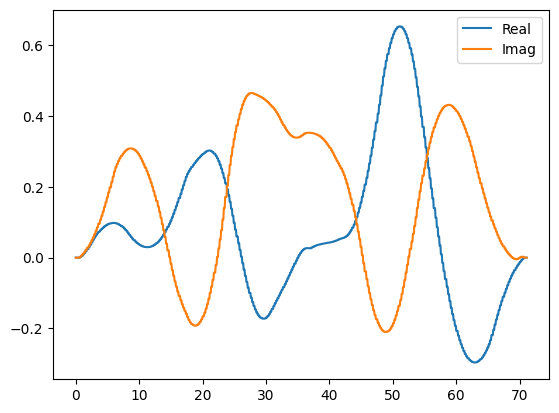

In [39]:
perturb_params = svd_directions.right_SV_linear_combo(jnp.array([
        -0.20666666666666667, 
        -0.014966666666666666, 
        -0.0016666666666666666, 
        0.
    ]), translate_args=True)
perturb_params["phase"] = 0.
sig = signal_parameterizations['sigX'](perturb_params)
sig.draw(0, T, 1000, function="envelope")

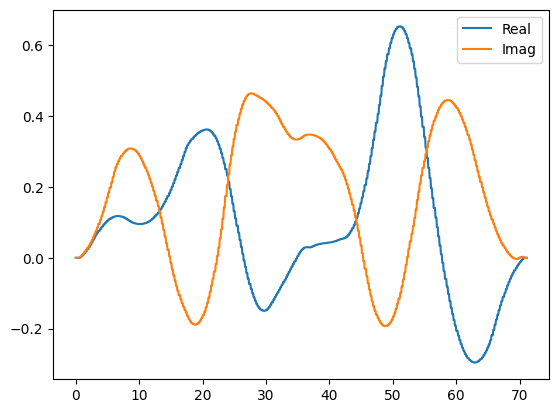

In [40]:
perturb_params = svd_directions.right_SV_linear_combo(0*jnp.array([
        -0.20666666666666667, 
        -0.014966666666666666, 
        -0.0016666666666666666, 
        0.
    ]), translate_args=True)
perturb_params["phase"] = 0.
sig = signal_parameterizations['sigX'](perturb_params)
sig.draw(0, T, 1000, function="envelope")